In [84]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from fredapi import Fred
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from forecastingGDP.data import get_data
from sklearn.preprocessing import MinMaxScaler




In [4]:
sys.path.append('/Users/Esteban/code/PhilippeLorang/forecastingGDP')

### Data

#### Retrieval

In [11]:
df=get_data()

In [13]:
df.shape

(434, 27)

In [21]:
#Number of NaN in df
df.isnull().sum().sum()

6553

In [31]:
#Number of NaN per columns
for col in df.columns:
    print(f'{col}: {df[col].isnull().sum().sum()}')

GDPC1: 137
INDPRO: 25
ATLSBUSRGEP: 417
TCU: 217
AMTMNO: 318
NEWORDER: 317
CFNAI: 218
UMCSENT: 170
MARTSMPCSM44000USS: 318
DSPIC96: 185
PCEC96: 357
UNRATE: 141
CE16OV: 141
PAYEMS: 105
LNU05026648: 325
CPIAUCSL: 137
PCEPILFE: 185
PPIACO: 1
IEAMGSN: 345
IEAXGS: 345
IMPCH: 289
BAMLH0A0HYM2: 336
SP500: 394
VIXCLS: 308
DGS10: 196
T10Y2Y: 254
DTWEXAFEGS: 372


In [38]:
###Test with the most complete features
df=df[['GDPC1','INDPRO', 'PAYEMS','PPIACO']].dropna()

In [42]:
df.head()

,GDPC1,INDPRO,PAYEMS,PPIACO
1947-01-01,2033.061,13.8059,43566.0,24.8
1947-04-01,2027.639,13.8149,43649.0,25.0
1947-07-01,2023.452,13.8420,43969.0,25.7
1947-10-01,2055.103,14.2202,44492.0,26.8
1948-01-01,2086.017,14.3643,44632.0,27.4


In [43]:
df.shape

(297, 4)

#### df_train & df_test split

In [50]:
# Time Serie split 
#We separate df into df_train and df_test such that the first 80% of the dataframe are in the training. 
#And the last 20% in the test set.

len_ = int(0.8*df.shape[0])
df_train = df[:len_]
df_test = df[len_:]

In [51]:
# Scale with MinMaxScale so they have the same range
columns = df.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

,GDPC1,INDPRO,PAYEMS,PPIACO
0,0.000726,0.002970,0.003578,0.000000
1,0.000316,0.003077,0.004476,0.001434
2,0.000000,0.003396,0.007935,0.006452
3,0.002390,0.007852,0.013589,0.014337
4,0.004724,0.009550,0.015102,0.018638


In [48]:
df_train.shape

(237, 4)

In [49]:
df_test.shape

(60, 4)

In [53]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random.
    """
    
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample

def split_subsample_sequence(df, length, df_mean=None):
    """Return one single sample (Xi, yi) containing one sequence each of length `length`"""
    features_names = ['INDPRO', 'PAYEMS', 'PPIACO']
    
    # Trick to save time during the recursive calls
    if df_mean is None:
        df_mean = df[features_names].mean()
        
    df_subsample = subsample_sequence(df, length).copy()
    
    # Let's drop any row without a target! We need targets to fit our model
    df_subsample.dropna(how='any', subset=['GDPC1'], inplace=True)
    
    # Create y_sample
    if df_subsample.shape[0] == 0: # Case if there is no targets at all remaining
        return split_subsample_sequence(df, length, df_mean) # Redraw by recursive call until it's not the case anymore
    y_sample = df_subsample[['GDPC1']]
    
    # Create X_sample
    X_sample = df_subsample[features_names]
    if X_sample.isna().sum().sum() !=0:  # Case X_sample has some NaNs
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, sequence_lengths):
    '''Return a dataset (X, y)'''
    X, y = [], []

    for length in sequence_lengths:
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    return X, y

In [59]:
# Here we define the parameter to generate our train/test sets
train_size = df_train.size
test_size = round(0.2 * train_size)

min_seq_len = 5
max_seq_len = 12

In [60]:
# Generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

In [63]:
#padding to make sure that our subsequences have the same lenght for computaiton purposes
X_train_pad = pad_sequences(X_train, value=-1000., dtype=float, padding='post', maxlen=12)
y_train_pad = pad_sequences(y_train, value=-1000., dtype=float, padding='post', maxlen=12)

X_test_pad = pad_sequences(X_test, value=-1000., dtype=float, padding='post', maxlen=12)
y_test_pad = pad_sequences(y_test, value=-1000., dtype=float, padding='post', maxlen=12)

X_train_pad.shape

(948, 12, 3)

### RNN MODEL

In [67]:
# Benchmark prediction
y_pred = np.mean([_ for elt in y_train for _ in elt])
bench_res = np.mean(np.abs([_-y_pred for elt in y_test for _ in elt]))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

Benchmark MAE on the test set : 0.7699


In [79]:
def init_model():
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1000., input_shape=(12,3)))
    model.add(layers.SimpleRNN(20, return_sequences=True, activation='tanh'))
    model.add(layers.SimpleRNN(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae'])
    
    return model

init_model().summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_10 (Masking)         (None, 12, 3)             0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 12, 20)            480       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 12, 10)            310       
_________________________________________________________________
dense_14 (Dense)             (None, 12, 5)             55        
_________________________________________________________________
dense_15 (Dense)             (None, 12, 1)             6         
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [91]:
model = init_model()

history = model.fit(X_train_pad, y_train_pad,
            validation_split=0.2,
            epochs=10, 
            batch_size=64,
            verbose=0)

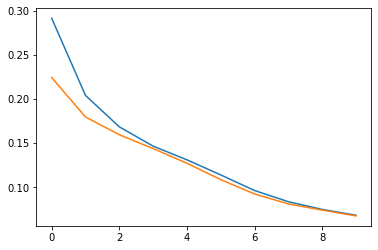

In [92]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [88]:
res = model.evaluate(X_test_pad, y_test_pad, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')

MAE on the test set : 0.1506


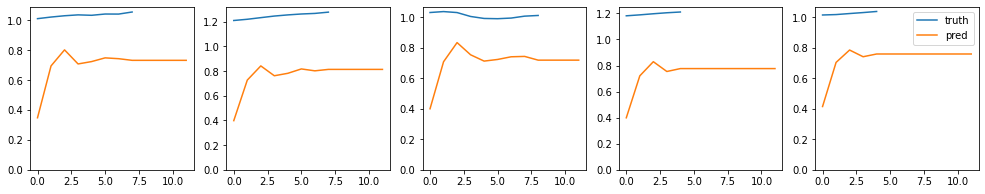

In [93]:
#true sequences vs predictions
plt.figure(figsize=(17,3))
for id_plot, id_seq in enumerate(np.random.randint(low=0,high=len(X_test),size=5)):
    plt.subplot(1, 5, id_plot+1)
    plt.plot(y_test[id_seq], label='truth')
    plt.plot(model.predict(X_test_pad)[id_seq], label='pred')
    plt.ylim(ymin=0)
plt.legend();